# Baseline results: Single visit models  

### train on train subset of ses2 data from subjects with two visits. Test on ses2 and ses3 scans from test_metadata subjects. 

In [1]:
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../")
from src.baseline_ML_utils import *

In [2]:
data_dir = "/home/nikhil/projects/brain_changes/data/"
exp_setup_dir = f"{data_dir}exp_setup"

ukbb_dir = f"{exp_setup_dir}/ukbb/"
adni_dir = f"{exp_setup_dir}/adni/"

# UKB Paths
ukbb_demographics_csv = f"{ukbb_dir}ukbb_exp_data_demographics.csv" 
ukbb_DKT_csv = f"{ukbb_dir}ukbb_exp_data_DKT.csv" 
ukbb_exp_setup_csv = f"{ukbb_dir}ukbb_exp_setup_shortterm.csv"
ukbb_longterm_csv = f"{ukbb_dir}ukbb_exp_setup_longterm.csv"

# ADNI Paths
adni_demographics_csv = f"{adni_dir}adni_exp_data_demographics.csv" 
adni_DKT_csv = f"{adni_dir}adni_exp_data_DKT.csv" 

# DKT fields and labels
ukbb_dkt_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_FS_DKT_Fields.csv"
ukbb_dkt_ct_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_DKT_CT_Fields.csv"

# ASEG fields and labels
ukbb_aseg_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_FS_ASEG_Fields.csv"
ukbb_aseg_vol_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_ASEG_vol_Fields.csv"

# Trained models
models_dir = f"{data_dir}results/models/"

### UKB short-term data
#### Labels
    - "age_at_ses2" --> age rounded in years 
    - "age_at_ses2 (calc)" --> floating point age calculated from years and months

#### Setups (input (dkt) --> output (age))
    - BL --> BL 
    - BL + FU --> BL
    - BL + FU --> BL + FU



#### Global configs

In [3]:

age_ses2_col = "age_at_ses2 (calc)" # "age_at_ses2" or "age_at_ses2 (calc)"
age_ses3_col = "age_at_ses3 (calc)" # "age_at_ses3" or "age_at_ses3 (calc)"

use_sex_col = False # Doesn't help much

demo_cols = ["participant_id","sex",age_ses2_col,age_ses3_col,"CV_subset"]

DKT_fields_df = pd.read_csv(ukbb_dkt_ct_fields)
DKT_fields_sorted = list(DKT_fields_df.sort_values(["hemi","roi"])["Field ID"].astype(str).values)


### visit configs for the experiments
    - Config `sessions` only impacts filtering of input features. The labels are specified as separate columns.
    - Multiple test_configs are possible with different `subset` of subjects or `sessions`
    - Input feature df needs to have multiple sessions as multipe rows and not a "longform" df with duplicate columns

In [4]:
save_model = True

# exp_setup
exp_setup_dict = {
                    "exp_single_visit":{
                    "features": DKT_fields_sorted, 
                    "train_config": {"subset": "train",                                
                                    "labels": [age_ses2_col],
                                    "sessions": ["ses-2"]},
                    "test_configs": {"BL (shortterm)": {"subset": "val",                                                    
                                                    "labels":[age_ses2_col],
                                                    "sessions": ["ses-2"]}, 
                                    "FU (shortterm)": {"subset": "val",
                                                    "labels":[age_ses3_col],
                                                    "sessions": ["ses-3"]}
                                    }
                    },
                    "exp_1.5_visits":{
                    "features": DKT_fields_sorted, 
                    "train_config": {"subset": "train",                                    
                                    "labels":[age_ses2_col],
                                    "sessions": ["ses-2","ses-3"]},
                    "test_configs": {"BL+FU (shortterm)": {"subset": "val",                                                   
                                                    "labels":[age_ses2_col],
                                                    "sessions": ["ses-2","ses-3"]}
                                    }
                    } ,
                    "exp_two_visits":{
                    "features": DKT_fields_sorted, 
                    "train_config": {"subset": "train",                                    
                                    "labels":[age_ses2_col,age_ses3_col],
                                    "sessions": ["ses-2","ses-3"]},
                    "test_configs": {"BL+FU (shortterm)": {"subset": "val",                                                   
                                                    "labels":[age_ses2_col,age_ses3_col],
                                                    "sessions": ["ses-2","ses-3"]}
                                    }
                    }         
}

n_jobs = 4
model_dict = {
            "Ridge": Ridge(), 
            # "RF": RandomForestRegressor(n_jobs=n_jobs, random_state=1)
            }

### Load data

In [5]:
ukbb_exp_setup_df = pd.read_csv(ukbb_exp_setup_csv)
train_ids = ukbb_exp_setup_df[ukbb_exp_setup_df["CV_subset"] == "train"]["participant_id"].values
val_ids = ukbb_exp_setup_df[ukbb_exp_setup_df["CV_subset"] == "val"]["participant_id"].values
exp_ids = list(set(train_ids).union(set(val_ids)))
ukbb_exp_setup_df = ukbb_exp_setup_df[ukbb_exp_setup_df["participant_id"].isin(exp_ids)][demo_cols]
ukbb_exp_setup_df = ukbb_exp_setup_df.rename(columns={"participant_id":"subject_id"})

print(f"n_train: {len(train_ids)}, n_val: {len(val_ids)}, exp_ids: {len(exp_ids)}")

# Read DKT
DKT_df = pd.read_csv(ukbb_DKT_csv)
DKT_df = DKT_df[DKT_df["subject_id"].isin(exp_ids)]

exp_data_df = pd.merge(ukbb_exp_setup_df, DKT_df, how="right", on="subject_id")

exp_data_df.head()


n_train: 3071, n_val: 342, exp_ids: 3413


,subject_id,sex,age_at_ses2 (calc),age_at_ses3 (calc),CV_subset,27174,27175,27176,27177,27178,...,27290,27291,27292,27293,27294,27295,27296,27297,session,proc_subset
0,sub-3239964,0,67.1,69.4,train,2.491,2.519,1.799,3.039,2.565,...,2.657,2.192,2.409,1.997,2.670,2.302,1.991,2.842,ses-2,pre_ohbm
1,sub-3239964,0,67.1,69.4,train,2.439,2.552,1.771,3.185,2.538,...,2.832,2.199,2.374,2.010,2.671,2.359,2.130,2.914,ses-3,pre_ohbm
2,sub-1247311,0,60.4,62.5,train,2.985,2.481,1.881,3.213,2.666,...,2.797,2.326,2.585,2.190,2.830,2.583,2.665,2.835,ses-2,pre_ohbm
3,sub-1247311,0,60.4,62.5,train,2.921,2.490,1.834,3.588,2.632,...,2.686,2.289,2.573,2.155,2.845,2.521,2.546,2.881,ses-3,pre_ohbm
4,sub-3102962,0,69.3,71.4,train,2.787,2.667,2.044,3.540,2.746,...,2.971,2.342,2.760,2.266,2.962,2.618,2.550,2.897,ses-2,pre_ohbm


### Run models

In [6]:
exp_perf_df = pd.DataFrame()
for exp_name, exp_config in exp_setup_dict.items():
    print(f"\nexp name: {exp_name}")

    train_data_dict, test_data_dict = get_ML_data(exp_data_df, exp_config, testdata_only=False)
    X_train, y_train = train_data_dict["train"]
    
    if exp_name == "exp_single_visit":        
        X_val, y_val = test_data_dict["BL (shortterm)"]
        X_val_FU, y_val_FU = test_data_dict["FU (shortterm)"]

    else:
        X_val, y_val = test_data_dict["BL+FU (shortterm)"]
        X_val_FU = None
        y_val_FU = None

    print(f"shapes X_CV: {X_train.shape}, y_CV: {y_train.shape}")
        
    model_perf_df = pd.DataFrame()
    for model_name, model_instance in model_dict.items():
        perf_df, model = get_brain_age_perf(model_instance, X_train, y_train, X_val, y_val, X_val_FU, y_val_FU, pretrained=False, cv=2)
        perf_df["model"] = model_name
        model_perf_df = model_perf_df.append(perf_df)

        if save_model:
            model_save_path = f"{models_dir}{exp_name}_{model_name}.joblib"
            dump(model, model_save_path) 

    model_perf_df["exp_name"] = exp_name
    exp_perf_df = exp_perf_df.append(model_perf_df)

exp_perf_df["visit_interval"] = "<= 3yr"



exp name: exp_single_visit
shapes X_CV: (3071, 62), y_CV: (3071,)
***Training a new model***

exp name: exp_1.5_visits
shapes X_CV: (3071, 124), y_CV: (3071,)
***Training a new model***

exp name: exp_two_visits
shapes X_CV: (3071, 124), y_CV: (3071, 2)
***Training a new model***


### Check performance on the longterm visits

### Load data

In [7]:
ukbb_exp_setup_df = pd.read_csv(ukbb_longterm_csv)
ukbb_exp_setup_df = ukbb_exp_setup_df[ukbb_exp_setup_df["CV_subset"]=="longterm_val"]

exp_ids = ukbb_exp_setup_df["participant_id"].values
ukbb_exp_setup_df = ukbb_exp_setup_df[ukbb_exp_setup_df["participant_id"].isin(exp_ids)][demo_cols]
ukbb_exp_setup_df = ukbb_exp_setup_df.rename(columns={"participant_id":"subject_id"})

print(f"exp_ids: {len(exp_ids)}")

# Read DKT
DKT_df = pd.read_csv(ukbb_DKT_csv)
DKT_df = DKT_df[DKT_df["subject_id"].isin(exp_ids)]

exp_data_df = pd.merge(ukbb_exp_setup_df, DKT_df, how="right", on="subject_id")

exp_data_df.head()


exp_ids: 258


,subject_id,sex,age_at_ses2 (calc),age_at_ses3 (calc),CV_subset,27174,27175,27176,27177,27178,...,27290,27291,27292,27293,27294,27295,27296,27297,session,proc_subset
0,sub-4499884,1,50.3,55.6,longterm_val,2.806,2.812,1.893,3.538,2.814,...,3.099,2.417,2.512,2.261,3.007,2.832,2.713,3.159,ses-2,post_ohbm
1,sub-4499884,1,50.3,55.6,longterm_val,2.846,2.854,1.826,3.321,2.708,...,3.199,2.465,2.529,2.253,2.965,2.847,2.676,3.133,ses-3,post_ohbm
2,sub-2554385,0,51.6,57.2,longterm_val,2.568,2.424,1.996,3.751,2.791,...,2.868,2.271,2.495,2.109,2.812,2.453,2.579,2.905,ses-2,post_ohbm
3,sub-2554385,0,51.6,57.2,longterm_val,2.548,2.471,1.937,3.803,2.767,...,2.768,2.305,2.561,2.111,2.849,2.525,2.552,3.030,ses-3,post_ohbm
4,sub-1720788,0,60.4,66.6,longterm_val,3.135,2.416,1.952,3.437,2.711,...,2.644,2.318,2.634,2.093,2.857,2.403,2.216,3.082,ses-2,post_ohbm


### Test models

In [8]:
# Setup
exp_setup_dict = {
                    "exp_single_visit":{
                    "features": DKT_fields_sorted, 
                    "test_configs": {"BL (longterm)": {"subset": "longterm_val",                                                    
                                                    "labels":[age_ses2_col],
                                                    "sessions": ["ses-2"]}, 
                                    "FU (longterm)": {"subset": "longterm_val",
                                                    "labels":[age_ses3_col],
                                                    "sessions": ["ses-3"]}
                                    }
                    },
                    "exp_1.5_visits":{
                    "features": DKT_fields_sorted, 
                    "test_configs": {"BL+FU (longterm)": {"subset": "longterm_val",                                                   
                                                    "labels":[age_ses2_col],
                                                    "sessions": ["ses-2","ses-3"]}
                                    }
                    },
                    "exp_two_visits":{
                    "features": DKT_fields_sorted, 
                    "test_configs": {"BL+FU (longterm)": {"subset": "longterm_val",                                                   
                                                    "labels":[age_ses2_col,age_ses3_col],
                                                    "sessions": ["ses-2","ses-3"]}
                                    }
                    }         
}

trained_model_list  = ["Ridge"]



In [9]:

exp_longterm_perf_df = pd.DataFrame()
for exp_name, exp_config in exp_setup_dict.items():
    print(f"\nexp name: {exp_name}")

    train_data_dict, test_data_dict = get_ML_data(exp_data_df, exp_config, testdata_only=True)
    
    if exp_name == "exp_single_visit":        
        X_val, y_val = test_data_dict["BL (longterm)"]
        X_val_FU, y_val_FU = test_data_dict["FU (longterm)"]

    else:
        X_val, y_val = test_data_dict["BL+FU (longterm)"]
        X_val_FU = None
        y_val_FU = None

    print(f"shapes X_val: {X_val.shape}, y_CV: {y_val.shape}")
        
    model_perf_df = pd.DataFrame()
    for model_name in trained_model_list:
        model_save_path = f"{models_dir}{exp_name}_{model_name}.joblib"
        model_instance = load(model_save_path) 
        X_train = None
        y_train = None
        perf_df, model = get_brain_age_perf(model_instance, X_train, y_train, X_val, y_val, X_val_FU, y_val_FU, pretrained=True)
        perf_df["model"] = model_name
        model_perf_df = model_perf_df.append(perf_df)
            
    model_perf_df["exp_name"] = exp_name
    exp_longterm_perf_df = exp_longterm_perf_df.append(model_perf_df)

exp_longterm_perf_df["visit_interval"] = "~ 4-7yr"


exp name: exp_single_visit
shapes X_val: (258, 62), y_CV: (258,)
***Using pretrained model***

exp name: exp_1.5_visits
shapes X_val: (258, 124), y_CV: (258,)
***Using pretrained model***

exp name: exp_two_visits
shapes X_val: (258, 124), y_CV: (258, 2)
***Using pretrained model***


### Combine long and short term perf

In [10]:
id_var_cols = ["exp_name","model","visit_interval"]
exp_perf_df = exp_perf_df.append(exp_longterm_perf_df)
exp_perf_df.groupby(id_var_cols).mean().reset_index()

,exp_name,model,visit_interval,y_test_BL,y_pred_BL,sq_err_BL,abs_err_BL,corr_BL,y_test_FU,y_pred_FU,sq_err_FU,abs_err_FU,corr_FU,delta_test,delta_pred
0,exp_1.5_visits,Ridge,<= 3yr,63.224854,62.998657,36.040735,4.825583,0.574869,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,exp_1.5_visits,Ridge,~ 4-7yr,56.795349,61.242555,55.506604,6.261904,0.566131,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,exp_single_visit,Ridge,<= 3yr,63.224854,62.916859,38.682924,5.082880,0.531193,65.509649,63.526399,41.883957,5.238608,0.541096,2.284795,0.609540
3,exp_single_visit,Ridge,~ 4-7yr,56.795349,61.211731,59.997448,6.584610,0.481599,62.072093,62.028569,35.158419,4.784016,0.557874,5.276744,0.816838
4,exp_two_visits,Ridge,<= 3yr,63.224854,62.998657,36.040735,4.825583,0.574869,65.509649,65.288483,36.196149,4.847468,0.571192,2.284795,2.289826
5,exp_two_visits,Ridge,~ 4-7yr,56.795349,61.242555,55.506604,6.261904,0.566131,62.072093,63.552598,36.604923,4.980588,0.571045,5.276744,2.310043


## Plots

### Absolute or squared error

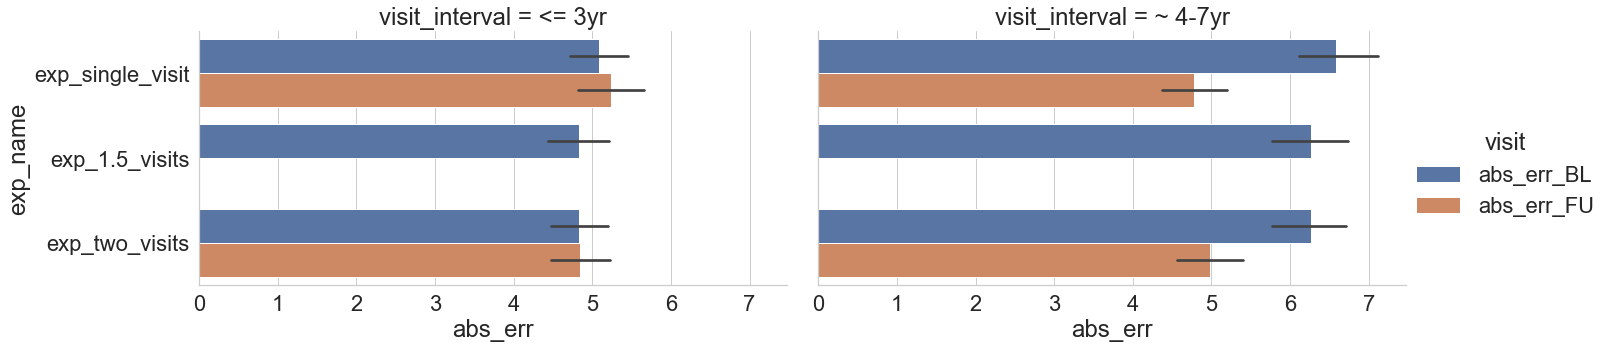

In [11]:
err_type = "abs_err"
model = "Ridge"
plot_df = exp_perf_df[id_var_cols + [f"{err_type}_BL",f"{err_type}_FU"]].copy()
plot_df = plot_df[plot_df["model"]==model]

plot_df_melt = plot_df.melt(
    id_vars = id_var_cols,
    var_name = "visit", 
    value_name = err_type,
)

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    # fig, ax = plt.subplots(figsize=(20,10))
    g = sns.catplot(x=err_type,y="exp_name", hue="visit", kind="bar", col="visit_interval", data=plot_df_melt, aspect=2)

### Brain Ageing consistency (temporal stability)

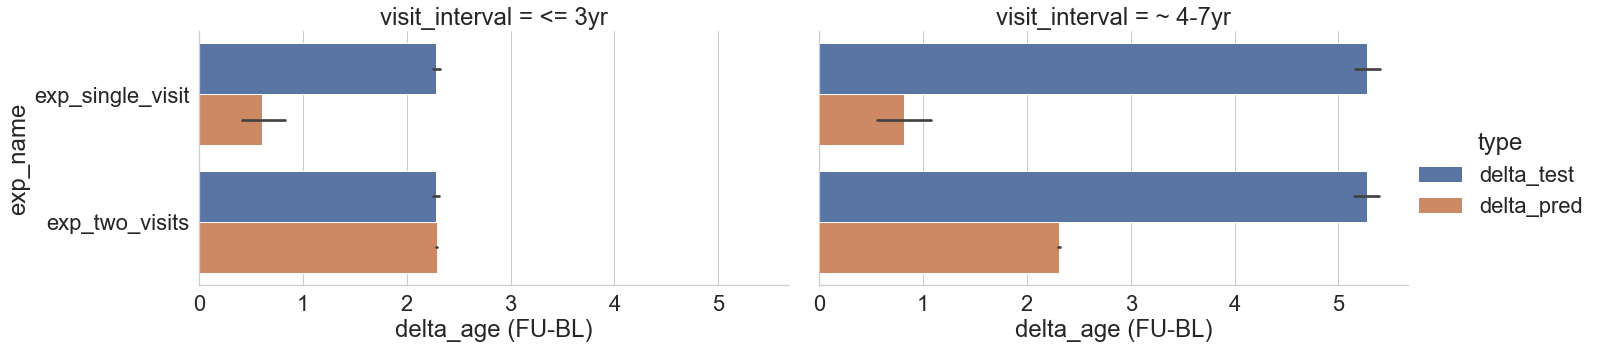

In [12]:
exp_list = ["exp_single_visit","exp_two_visits"]
plot_df = exp_perf_df[exp_perf_df["exp_name"].isin(exp_list)][id_var_cols + ["delta_test","delta_pred"]].copy()

plot_df_melt = plot_df.melt(
    id_vars = id_var_cols,
    var_name = "type", 
    value_name = "delta_age (FU-BL)",
)
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    # fig, ax = plt.subplots(figsize=(20,10))
    g = sns.catplot(x="delta_age (FU-BL)",y="exp_name", hue="type", kind="bar", col="visit_interval", data=plot_df_melt, aspect=2)

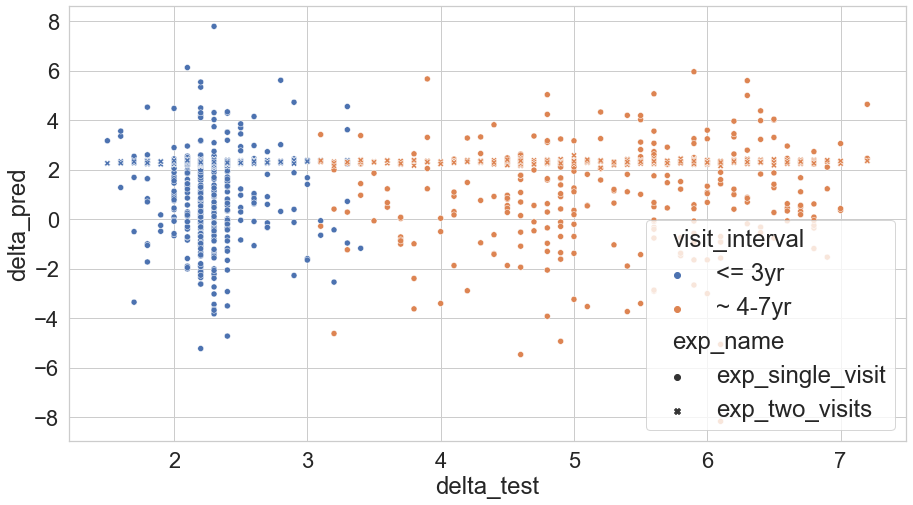

In [13]:
exp_list = ["exp_single_visit","exp_two_visits"]


plot_df = exp_perf_df[exp_perf_df["exp_name"].isin(exp_list)][id_var_cols + ["y_test_BL","delta_test","delta_pred"]].copy()

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(15,8))
    g = sns.scatterplot(x="delta_test", y="delta_pred", style="exp_name", hue="visit_interval", data=plot_df, ax=ax)
    

# features: ses-2 
    # without sex col
    # model: Ridge, val mae: 5.083, correlation: 0.531
    # model: RF, val mae: 5.436, correlation: 0.445

    # with sex col
    # model: Ridge, val mae: 5.085, correlation: 0.531
    # model: RF, val mae: 5.458, correlation: 0.436

# features: ses-2 and 3 
    # without sex col
    # model: Ridge, val mae: 4.826, correlation: 0.575

    # with sex col
    # model: Ridge, val mae: 4.820, correlation: 0.574